# 2. Data Preprocessing & Converting to Cell2Sentence Format

In this notebook, we will:
1. Load a sample preprocessed single-cell dataset (PBMC 3k from Scanpy).
2. Convert the default log1p data transformation (which uses the natural logarithm) to base 10.
3. Convert the data into 'cell sentences' using Cell2Sentence.

## Learning Objectives
- Understand how to handle scRNA-seq data with AnnData.
- Apply the data transformation to allow reverse encoding of cell sentences to transcriptome profiles.
- Generate cell sentences with the top genes for each cell.

## 2.1. Load the PBMC3k dataset
We'll use the built-in processed dataset from Scanpy. It contains ~2700 peripheral blood mononuclear cells.


In [1]:
import os
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
import random
from collections import Counter
import pandas as pd

# Cell2Sentence imports
import cell2sentence as cs
from cell2sentence.utils import benchmark_expression_conversion, reconstruct_expression_from_cell_sentence

import tqdm as notebook_tqdm

/home/pieterdb/anaconda3/envs/cell2sentence_env/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
SEED = 1234
random.seed(SEED)
np.random.seed(SEED)

In [3]:
# Load dataset
adata = sc.datasets.pbmc3k_processed()
adata

AnnData object with n_obs × n_vars = 2638 × 1838
    obs: 'n_genes', 'percent_mito', 'n_counts', 'louvain'
    var: 'n_cells'
    uns: 'draw_graph', 'louvain', 'louvain_colors', 'neighbors', 'pca', 'rank_genes_groups'
    obsm: 'X_pca', 'X_tsne', 'X_umap', 'X_draw_graph_fr'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

The AnnData object typically has:
- `.X` for the gene expression matrix
- `.obs` for cell metadata
- `.var` for gene metadata


In [4]:
adata.obs.head()

,n_genes,percent_mito,n_counts,louvain
index,,,,
AAACATACAACCAC-1,781,0.030178,2419.0,CD4 T cells
AAACATTGAGCTAC-1,1352,0.037936,4903.0,B cells
AAACATTGATCAGC-1,1131,0.008897,3147.0,CD4 T cells
AAACCGTGCTTCCG-1,960,0.017431,2639.0,CD14+ Monocytes
AAACCGTGTATGCG-1,522,0.012245,980.0,NK cells


Rename the adata.obs 'louvain' column to 'cell_type'

In [5]:
adata.obs.rename(columns={'louvain': 'cell_type'}, inplace=True)

Add a column 'organism' with the value 'Homo sapiens' to adata.obs

In [6]:
adata.obs["organism"] = "Homo sapiens"

In [7]:
adata.var.head()

,n_cells
index,
TNFRSF4,155
CPSF3L,202
ATAD3C,9
C1orf86,501
RER1,608


/home/pieterdb/anaconda3/envs/cell2sentence_env/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored


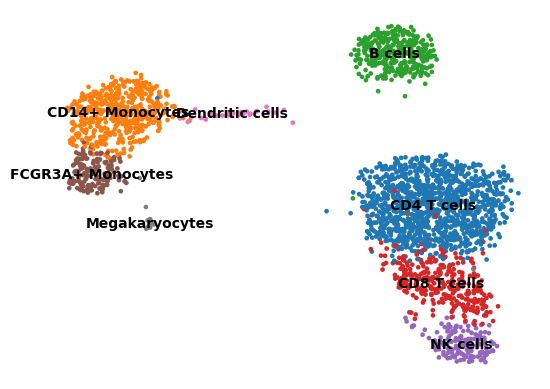

In [8]:
sc.pl.umap(
    adata, color="cell_type", legend_loc="on data", title="", frameon=False
)

## Data preprocessing - Note
Cell2Sentence only deviates from the standard preprocessing and normalization pipeline in that the log transformation is done with a base of 10 rather than natural logarithm.
The PBMC 3k processed data set was transformed using the default log1p (which uses the natural logarithm), You can convert the values to base 10 by dividing by ln(10). If your AnnData object is stored in adata and the log1p’d data is in adata.X, you can do:

````python
import numpy as np
adata.X = adata.X / np.log(10)
````

This works because for any value y = ln(x+1), you have log10(x+1) = ln(x+1) / ln(10). Make sure to verify that adata.X stores the transformed data and that any downstream analysis expects the new log scale.



In [9]:
adata.X = adata.X / np.log(10)

Set all negative values to 0.0

In [10]:
import numpy as np
from scipy.sparse import issparse

if issparse(adata.X):
    adata.X.data[adata.X.data < 0] = 0.0
else:
    adata.X[adata.X < 0] = 0.0

In [11]:
SAVE_PATH = "./data/pbmc3k_final.h5ad"

In [12]:
adata.write_h5ad(SAVE_PATH)

## 2.3. Converting to Cell2Sentence (CSData)
Now that we have preprocessed and normalized data loaded, we will perform the conversion to cell sentences. In this section, we will transform our AnnData object containing our single-cell dataset into a Cell2Sentence (C2S) dataset by calling the functions of the CSData class in the C2S code base. Full documentation for the functions of the CSData class can be found in the documentation page of C2S.

First, we define which columns in adata.obs we would like to keep in our C2S dataset. The 'louvain' (Cell type) will be useful to keep, so we will define a list with this label:
We'll transform the `AnnData` into C2S's `CSData` object, then create 'cell sentences' with the top genes in rank order.

In [13]:
adata.obs.head()

,n_genes,percent_mito,n_counts,cell_type,organism
index,,,,,
AAACATACAACCAC-1,781,0.030178,2419.0,CD4 T cells,Homo sapiens
AAACATTGAGCTAC-1,1352,0.037936,4903.0,B cells,Homo sapiens
AAACATTGATCAGC-1,1131,0.008897,3147.0,CD4 T cells,Homo sapiens
AAACCGTGCTTCCG-1,960,0.017431,2639.0,CD14+ Monocytes,Homo sapiens
AAACCGTGTATGCG-1,522,0.012245,980.0,NK cells,Homo sapiens


In [14]:
adata_obs_cols_to_keep = ["cell_type","organism"]

Now, we create a CSData object using the adata_to_arrow() class function of the CSData model class. This will return us a Huggingface PyArrow dataset (see https://huggingface.co/docs/datasets/en/about_arrow)

In [15]:
# Create CSData object
arrow_ds, vocabulary = cs.CSData.adata_to_arrow(
    adata=adata, 
    random_state=SEED, 
    sentence_delimiter=' ',
    label_col_names=adata_obs_cols_to_keep
)

100%|██████████| 2638/2638 [00:00<00:00, 18772.83it/s]


Let's examine the arrow dataset which was created:

In [16]:
arrow_ds

Dataset({
    features: ['cell_name', 'cell_sentence', 'cell_type', 'organism'],
    num_rows: 2638
})

We can see that our 2638 cells have now been converted into rows of a Dataset object. The metadata columns of our adata object have been preserved, and two new columns have been added: cell_name and cell_sentence. These columns contain unique cell identifiers as well as cell sentences, respectively. Each cell sentence consists of a string of space-separated gene names, in order of descending expression value. For more details about the cell sentence creation process, please refer to the C2S paper.

We can look at one arrow dataset example as follows:

In [17]:
sample_idx = 0
arrow_ds[sample_idx]

{'cell_name': 'AAACATACAACCAC-1',
 'cell_sentence': 'SPRY1 ZBTB10 ANKRD27 DNMT3A ING5 ZBED5-AS1 NOL7 PAICS HELQ NFKBIL1 TNFRSF25 RIOK1 C19ORF52 MNAT1 APH1B WDR55 MOCS2 RFC2 NR2C2AP C17ORF59 TRABD2A LAMP2 NOL11 ILF3 THEM4 MRPS33 SNRNP27 CCDC174 FXN PHKG2 RRAGC MRPS18A CRLS1 GFER COMMD4 PRR5 SPNS1 SRSF6 CARS GALT POLDIP2 EBNA1BP2 SEPHS2 TRIM69 DIAPH1 ZNF32 SND1 OXLD1 RP11-139H15.1 MFSD10 ISCA2 CLIC3 DDX17 RGS14 GIT2 REXO2 SNHG8 EMB ECHDC1 TMEM205 COMMD8 TREX1 RNF113A TTC3 PEX16 SIAH2 SLC25A11 HOPX PITHD1 LYAR SF3B1 C9ORF142 TMEM165 CCL5 SMS MPC2 LSM14A TCP1 YPEL3 SELPLG PPIG HNRNPH3 C19ORF24 ZC3H15 PPT1 ACTR2 CCT4 EFHD2 MYADM FYB ALKBH7 TERF2IP TMEM14B STUB1 VAMP5 APOBEC3G SRSF5 GADD45B HSP90AA1 SCP2 PNRC1 ARRB2 PSMC5 CTSW ABRACL FUS TRAF3IP3 CD48 ATP5C1 SNX3 ARPC4 CASP4 SRP9 PDIA3 UBE2D3 EIF3D ATP5A1 SF3B5 CEBPB HINT1 RBM3 LTB ARL6IP5 GIMAP4 LIMD2 ID2 UBXN1 VAMP8 YWHAB GTF3A CAPZB ATP5D UBB COTL1 GSTP1 CD37 ARPC1B PTPRCAP LGALS1 ARHGAP6 PDZK1IP1 INSL3 RP11-527L4.5 SPOCD1',
 'cell_type':

When we print out an entire sample, we can see that it is a Python dictionary. The cell sentence contains a sentence of gene names ordered by descending expression level, giving a rank-based gene name representation of the cell. The rest of the columns of adata.obs which were specified also show up in the dataset sample.

This dataset format will allow us to work with cell sentence datasets in an efficient manner. For more details on the cell sentence transformation, please review the Cell2Sentence paper: https://openreview.net/pdf?id=EWt5wsEdvc

In [18]:
len(arrow_ds[sample_idx]["cell_sentence"].split(" "))  # Cell 0 has 1838 nonzero expressed genes, yielding a sentence of 1838 gene names separated by spaces.

144

Next, we will examine the vocabulary which was generated:

In [19]:
print(type(vocabulary))
print(len(vocabulary))

<class 'collections.OrderedDict'>
1838


We can see that vocabulary is an OrderedDict of gene features, corresponding to the original 1838 genes in our adata object. The OrderedDict denotes the gene features present in our single-cell dataset, and also stores the number of cells that gene was expressed in.

In [20]:
list(vocabulary.items())[:10]

[('TNFRSF4', 172),
 ('CPSF3L', 198),
 ('ATAD3C', 8),
 ('C1ORF86', 492),
 ('RER1', 596),
 ('TNFRSF25', 168),
 ('TNFRSF9', 76),
 ('CTNNBIP1', 166),
 ('SRM', 344),
 ('UBIAD1', 110)]

## CSData creation
Now that our AnnData object is converted into an arrow dataset, we can create a CSData object to wrap around our arrow dataset. This will help us manage the arrow dataset, keeping it saved on disk and out of memory until we need the data for inference or finetuning.

In [21]:
c2s_save_dir = "./c2s_api_testing"  # C2S dataset will be saved into this directory
c2s_save_name = "PBMC_3K_tutorial1"  # This will be the name of our C2S dataset on disk

In [22]:
csdata = cs.CSData.csdata_from_arrow(
    arrow_dataset=arrow_ds, 
    vocabulary=vocabulary,
    save_dir=c2s_save_dir,
    save_name=c2s_save_name,
    dataset_backend="arrow"
)

Saving the dataset (1/1 shards): 100%|██████████| 2638/2638 [00:00<00:00, 434911.13 examples/s]


In [23]:
print(csdata)

CSData Object; Path=./c2s_api_testing/PBMC_3K_tutorial1, Format=arrow


The csdata object simply saves our arrow dataset onto disk and keeps a reference to the path. This wrapper class will work in concert with other classes such as CSModel and task functions to load the dataset whenever necessary, so that we avoid holding the C2S dataset in memory when it is not necessary.

We can retrieve and view cell sentences by calling the get_sentence_strings() function:

In [24]:
cell_sentences_list = csdata.get_sentence_strings()

In [25]:
len(cell_sentences_list)

2638

In [26]:
def print_first_N_genes(cell_sentence_str: str, top_k_genes: int, delimiter: str = " "):
    """Helper function to print K genes of a cell sentence."""
    print(delimiter.join(cell_sentence_str.split(delimiter)[:top_k_genes]))

In [27]:
print_first_N_genes(cell_sentences_list[0], top_k_genes=100)

SPRY1 ZBTB10 ANKRD27 DNMT3A ING5 ZBED5-AS1 NOL7 PAICS HELQ NFKBIL1 TNFRSF25 RIOK1 C19ORF52 MNAT1 APH1B WDR55 MOCS2 RFC2 NR2C2AP C17ORF59 TRABD2A LAMP2 NOL11 ILF3 THEM4 MRPS33 SNRNP27 CCDC174 FXN PHKG2 RRAGC MRPS18A CRLS1 GFER COMMD4 PRR5 SPNS1 SRSF6 CARS GALT POLDIP2 EBNA1BP2 SEPHS2 TRIM69 DIAPH1 ZNF32 SND1 OXLD1 RP11-139H15.1 MFSD10 ISCA2 CLIC3 DDX17 RGS14 GIT2 REXO2 SNHG8 EMB ECHDC1 TMEM205 COMMD8 TREX1 RNF113A TTC3 PEX16 SIAH2 SLC25A11 HOPX PITHD1 LYAR SF3B1 C9ORF142 TMEM165 CCL5 SMS MPC2 LSM14A TCP1 YPEL3 SELPLG PPIG HNRNPH3 C19ORF24 ZC3H15 PPT1 ACTR2 CCT4 EFHD2 MYADM FYB ALKBH7 TERF2IP TMEM14B STUB1 VAMP5 APOBEC3G SRSF5 GADD45B HSP90AA1 SCP2


In [28]:
print_first_N_genes(cell_sentences_list[1], top_k_genes=100)

RP11-145M9.4 OSBPL1A CISD1 PPP1R14A CTNND1 FAM212A WDR91 CD1C ZNF468 FCRL2 ATG16L1 ARHGEF7 TBC1D23 OTUD5 ADIPOR2 BANP AIM2 GSTZ1 SLC25A11 SPEN LPIN1 P2RX5 RNF14 KIAA0040 SIN3A TFAM MZB1 ARHGAP24 CEP164 PPP2R3C PGM1 MOB2 PNOC NCR3 MS4A1 ATAD1 IRF8 GNPTAB LUC7L VPS13C PRKACB SPIB STAU1 TMEM80 C16ORF74 PRKD2 HLA-DOB API5 DCAF8 CTNNBL1 LINC00926 C10ORF32 BRWD1 ODC1 ARL16 FN3KRP NUDT16L1 TRIM14 PARP1 CCND2 EAF2 TMEM141 SWAP70 GALK1 RELT POLD2 PRKCD UBXN1 MARCH2 YIPF5 TRPV2 RRAGC MAP3K8 NT5C NKAP C1ORF35 DTYMK CD82 GFER RBM5 RAB1B MIS18BP1 FNBP4 KLF13 NAT9 SKAP2 DNTTIP1 MRPL19 C20ORF27 ARGLU1 PRKCB C17ORF62 DRAM2 GABARAPL2 YPEL3 TGOLN2 PPA2 OARD1 STX16 TCP1


## Cell Sentence Transformation Benchmarking
We have successfully converted our single-cell dataset into cell sentences using the conversion functions, however it would be useful to know how well the conversion did, and how much expression information was lost when we switched to a rank ordering of genes rather than exact expression values.

In the C2S paper, a strong linear relationship was found between the log of the rank of a gene and its normalized expression value. We can similarly examine our rank transformation and reconstruction ability of the original expression by calling a rank transformation benchmarking utility function. This function will:

Fit a linear model on the ranks and expression of the original data, which can be used to reconstruct expression from rank
Save plots of log rank vs log expression and log expression vs reconstructed expression from rank
First, we define a path where the plots for the benchmarking and reconstruction will be saved:

In [29]:
output_path = os.path.join(c2s_save_dir, c2s_save_name)
output_path

'./c2s_api_testing/PBMC_3K_tutorial1'

In [30]:
transformation_benchmarking_save_name = "inverse_transformation_testing_tutorial_2"

We can call the benchmarking function with our output directory, as well as the normalized expression of our AnnData object. To avoid benchmarking on too many data points, we set a sample_size of cells to benchmark the rank transformation on 1024.

In [31]:
from scipy.sparse import csr_matrix

# Convert adata.X to a sparse matrix
sparse_matrix = csr_matrix(adata.X)

benchmark_expression_conversion(
    benchmark_output_dir=output_path,
    save_name=transformation_benchmarking_save_name,
    normalized_expression_matrix=sparse_matrix,
    sample_size=1024,
)

Benchmarking with a sample dataset of size 1024


/home/pieterdb/anaconda3/envs/cell2sentence_env/lib/python3.8/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 6.4 x 4.8 in image.
/home/pieterdb/anaconda3/envs/cell2sentence_env/lib/python3.8/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: ./c2s_api_testing/PBMC_3K_tutorial1/inverse_transformation_testing_tutorial_2_benchmark/normalized_expression_vs_log_rank.png
/home/pieterdb/anaconda3/envs/cell2sentence_env/lib/python3.8/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 6.4 x 4.8 in image.
/home/pieterdb/anaconda3/envs/cell2sentence_env/lib/python3.8/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: ./c2s_api_testing/PBMC_3K_tutorial1/inverse_transformation_testing_tutorial_2_benchmark/reconstructed_expression.png


Now, we can retrieve the slope and intercept of the linear model which was fit to predict expression from rank

In [32]:
metrics_df = pd.read_csv(os.path.join(output_path, transformation_benchmarking_save_name + "_benchmark", "c2s_transformation_metrics.csv"))
metrics_df.shape

(1, 11)

In [33]:
metrics_df

,experiment,x_axis,y_axis,threshold,slope,intercept,r_squared,pearson_r_statistic,pearson_r_pvalue,spearman_r_statistic,spearman_r_pvalue
0,Normalized Expression vs Log Rank,log_rank_normalized_expression,normalized_expression,3,-1.748812,4.166513,0.878119,0.93708,0.0,0.917747,0.0


We can see here the slope and intercept of the linear model which was fit on the log rank versus normalized expression on our sample of cells. Furthermore, we can see correlation statistics of the inverse reconstruction, where the linear model predicts the original expression based on the rank of the gene.

We can see that the linear model achieves 0.88 R^2. This indicates that most of the variance in the data is preserved when converting to rank-ordered cell sentences and then recovering the expression from rank. This allows us to utilize cell sentences and LLMs without worry about losing too much information when converting back to expression.

In [34]:
slope = metrics_df.iloc[0]["slope"]
intercept = metrics_df.iloc[0]["intercept"]
print("slope:", slope)
print("intercept:", intercept)

slope: -1.7488124858727696
intercept: 4.166513349050543


## Reconstruct Cell Expression From Cell Sentences
To further see the ability of the linear model to reconstruct original gene expression from rank in the cell sentences, in this section we will reconstruct expression vectors from cell sentences and visualize them against the original data.

First, we need to create a list of the gene names in our vocabulary. This will determine the ordering of genes in the expression vector we reconstruct:

In [35]:
vocab_list = list(vocabulary.keys())
print(len(vocab_list))
vocab_list[:4]

1838


['TNFRSF4', 'CPSF3L', 'ATAD3C', 'C1ORF86']

Now, we will first reconstruct a single expression vector:

In [36]:
print(len(cell_sentences_list))
print_first_N_genes(cell_sentences_list[0], top_k_genes=100)

2638
SPRY1 ZBTB10 ANKRD27 DNMT3A ING5 ZBED5-AS1 NOL7 PAICS HELQ NFKBIL1 TNFRSF25 RIOK1 C19ORF52 MNAT1 APH1B WDR55 MOCS2 RFC2 NR2C2AP C17ORF59 TRABD2A LAMP2 NOL11 ILF3 THEM4 MRPS33 SNRNP27 CCDC174 FXN PHKG2 RRAGC MRPS18A CRLS1 GFER COMMD4 PRR5 SPNS1 SRSF6 CARS GALT POLDIP2 EBNA1BP2 SEPHS2 TRIM69 DIAPH1 ZNF32 SND1 OXLD1 RP11-139H15.1 MFSD10 ISCA2 CLIC3 DDX17 RGS14 GIT2 REXO2 SNHG8 EMB ECHDC1 TMEM205 COMMD8 TREX1 RNF113A TTC3 PEX16 SIAH2 SLC25A11 HOPX PITHD1 LYAR SF3B1 C9ORF142 TMEM165 CCL5 SMS MPC2 LSM14A TCP1 YPEL3 SELPLG PPIG HNRNPH3 C19ORF24 ZC3H15 PPT1 ACTR2 CCT4 EFHD2 MYADM FYB ALKBH7 TERF2IP TMEM14B STUB1 VAMP5 APOBEC3G SRSF5 GADD45B HSP90AA1 SCP2


In [37]:
expression_vector = reconstruct_expression_from_cell_sentence(
    cell_sentence_str=cell_sentences_list[0],
    delimiter=" ",
    vocab_list=vocab_list,
    slope=slope,
    intercept=intercept,
)

In [38]:
print(type(expression_vector))
print(expression_vector.shape)
print(expression_vector.dtype)

<class 'numpy.ndarray'>
(1838,)
float32


In [39]:
expression_vector

array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)

In [40]:
expression_vector.sum()

163.22195

In [41]:
print(len(cell_sentences_list[0].split(" ")))
print(np.nonzero(expression_vector)[0].shape)

144
(144,)


We can see that the function reconstruct_expression_from_cell_sentence() has performed the inverse reconstruction on the cell sentence, using the rank of each gene in the cell sentence to predict its original expression using the linear model we fitted earlier:

- predicted_expression = intercept + (slope * log(rank_of_gene))

We can now repeat this and reconstruct the entire original dataset:

In [42]:
from tqdm import tqdm

all_reconstructed_expression_vectors = []
for idx in tqdm(range(len(cell_sentences_list))):
    expression_vector = reconstruct_expression_from_cell_sentence(
        cell_sentence_str=cell_sentences_list[idx],
        delimiter=" ",
        vocab_list=vocab_list,
        slope=slope,
        intercept=intercept,
    )
    all_reconstructed_expression_vectors.append(expression_vector)

all_reconstructed_expression_vectors = np.stack(all_reconstructed_expression_vectors)

100%|██████████| 2638/2638 [00:00<00:00, 11674.18it/s]


In [43]:
all_reconstructed_expression_vectors.shape

(2638, 1838)

Let's now make a new AnnData object, copying the .obs and .var from our original adata, but putting in our reconstructed expression vectors

In [44]:
import scipy

all_reconstructed_expression_vectors = scipy.sparse.csr_array(all_reconstructed_expression_vectors)
all_reconstructed_expression_vectors

<2638x1838 sparse array of type '<class 'numpy.float32'>'
	with 461212 stored elements in Compressed Sparse Row format>

In [45]:
import anndata

reconstructed_adata = anndata.AnnData(
    X=all_reconstructed_expression_vectors,
    obs=adata.obs.copy(),
    var=adata.var.copy()
)
reconstructed_adata

AnnData object with n_obs × n_vars = 2638 × 1838
    obs: 'n_genes', 'percent_mito', 'n_counts', 'cell_type', 'organism'
    var: 'n_cells'

Quickly verify that the original adata.var gene list ordering matches the vocab_list which we reconstructed vectors with:

In [46]:
adata.var.head()

,n_cells
index,
TNFRSF4,155
CPSF3L,202
ATAD3C,9
C1orf86,501
RER1,608


In [47]:
vocab_list[:5]

['TNFRSF4', 'CPSF3L', 'ATAD3C', 'C1ORF86', 'RER1']

## Plotting Reconstructed Expression Vectors
Now we will plot original data and reconstructed expression vectors side by side, to verify that the cell sentence transformation has preserved most of the original variance of the data.

First, we will remove the extra attributes of our original adata object, since we will need to create a new joint UMAP.

In [48]:
del adata.uns
del adata.obsm
del adata.varm
del adata.obsp

In [49]:
adata

AnnData object with n_obs × n_vars = 2638 × 1838
    obs: 'n_genes', 'percent_mito', 'n_counts', 'cell_type', 'organism'
    var: 'n_cells'

In [50]:
adata.obs["c2s_data_label"] = ["Original Data"] * adata.obs.shape[0]
reconstructed_adata.obs["c2s_data_label"] = ["Reconstructed From Cell Sentences"] * reconstructed_adata.obs.shape[0]

In [51]:
combined_adata = anndata.concat([adata, reconstructed_adata], axis=0)
combined_adata

/home/pieterdb/anaconda3/envs/cell2sentence_env/lib/python3.8/site-packages/anndata/_core/merge.py:1111: UserWarning: Only some AnnData objects have `.raw` attribute, not concatenating `.raw` attributes.
/home/pieterdb/anaconda3/envs/cell2sentence_env/lib/python3.8/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


AnnData object with n_obs × n_vars = 5276 × 1838
    obs: 'n_genes', 'percent_mito', 'n_counts', 'cell_type', 'organism', 'c2s_data_label'

In [52]:
combined_adata.obs_names_make_unique()

In [53]:
combined_adata.var = adata.var.copy()

In [54]:
combined_adata.obs = combined_adata.obs[["cell_type", "c2s_data_label"]]


In [55]:
combined_adata

AnnData object with n_obs × n_vars = 5276 × 1838
    obs: 'cell_type', 'c2s_data_label'
    var: 'n_cells'

We can now run PCA, Scanpy's neighbors algorithm, and then the UMAP algorithm:

In [56]:
sc.tl.pca(combined_adata)

In [57]:
sc.pp.neighbors(combined_adata)

In [58]:
sc.tl.umap(combined_adata)

In [59]:
combined_adata

AnnData object with n_obs × n_vars = 5276 × 1838
    obs: 'cell_type', 'c2s_data_label'
    var: 'n_cells'
    uns: 'pca', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [60]:
combined_adata[combined_adata.obs["c2s_data_label"] == "Reconstructed From Cell Sentences", :]

View of AnnData object with n_obs × n_vars = 2638 × 1838
    obs: 'cell_type', 'c2s_data_label'
    var: 'n_cells'
    uns: 'pca', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

/home/pieterdb/anaconda3/envs/cell2sentence_env/lib/python3.8/site-packages/anndata/_core/anndata.py:1230: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
/home/pieterdb/anaconda3/envs/cell2sentence_env/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
/home/pieterdb/anaconda3/envs/cell2sentence_env/lib/python3.8/site-packages/anndata/_core/anndata.py:1230: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
/home/pieterdb/anaconda3/envs/cell2sentence_env/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored


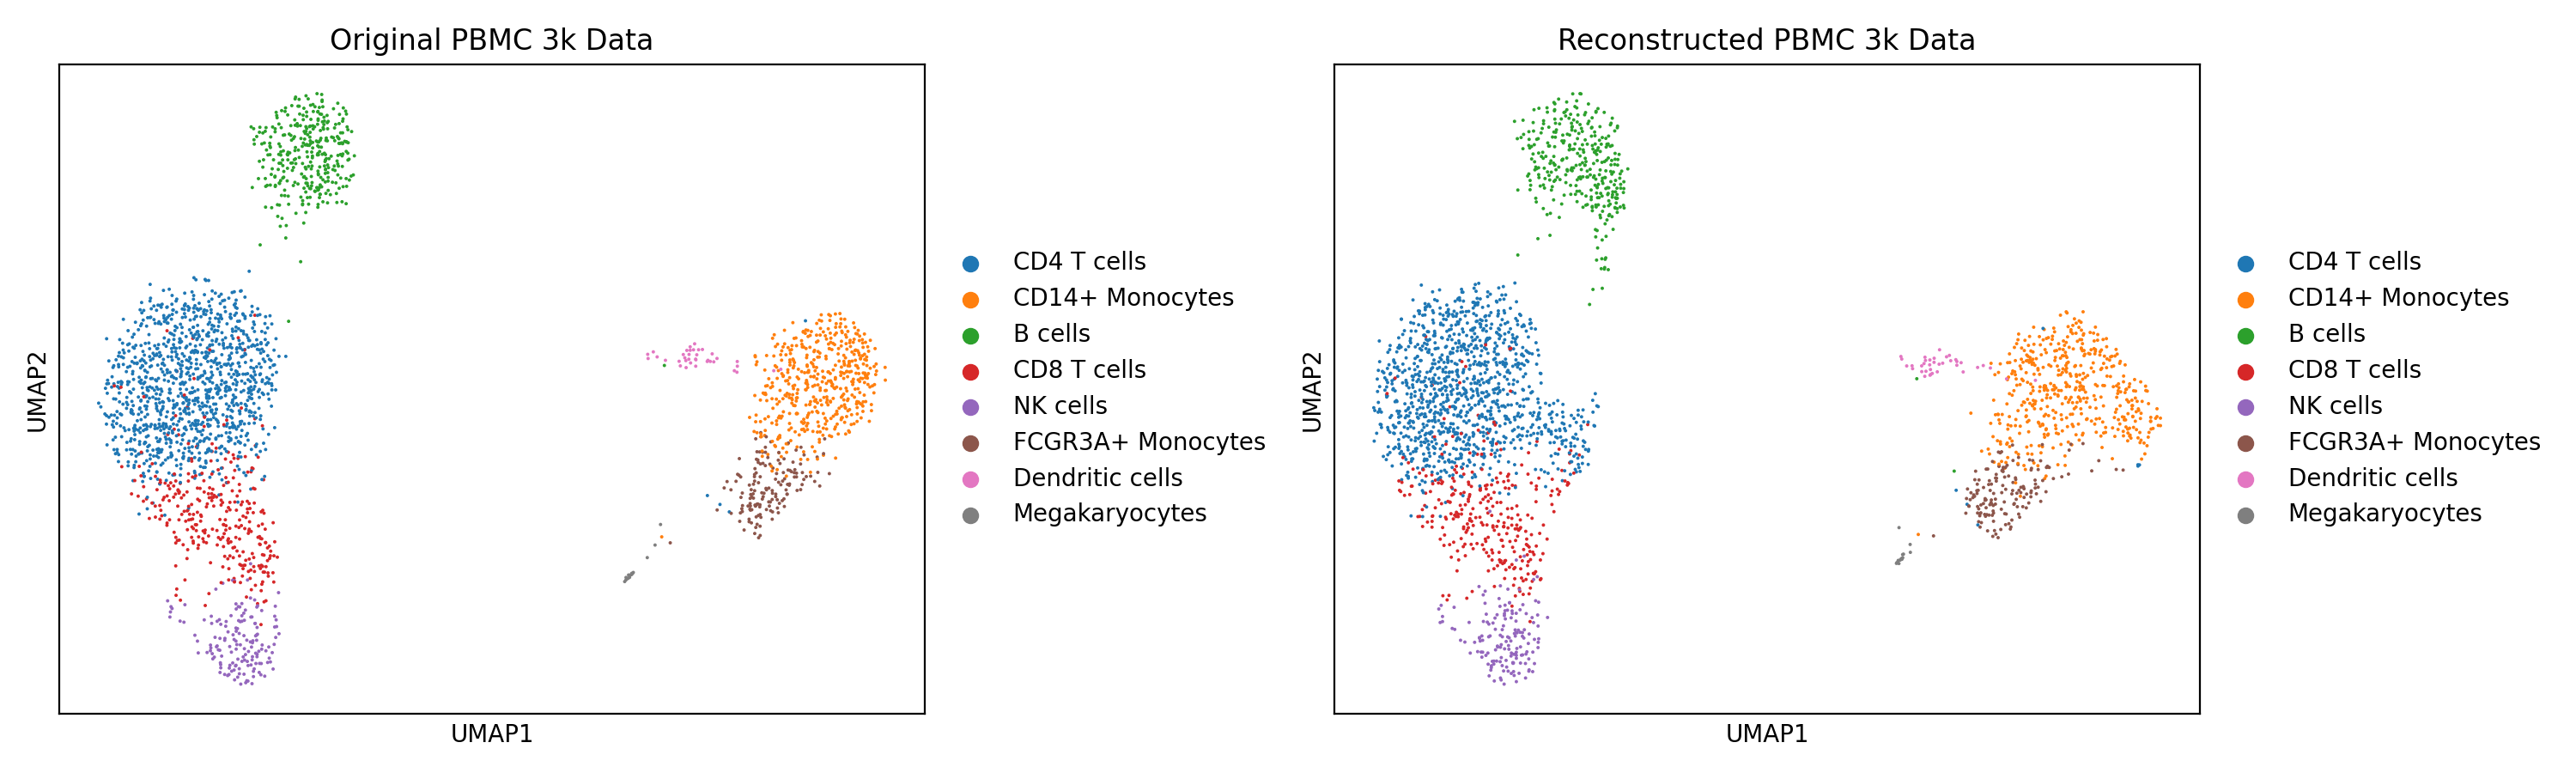

/home/pieterdb/anaconda3/envs/cell2sentence_env/lib/python3.8/site-packages/anndata/_core/anndata.py:1230: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
/home/pieterdb/anaconda3/envs/cell2sentence_env/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored


<Figure size 640x480 with 0 Axes>

In [61]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4.5))
sc.pl.umap(
    combined_adata[combined_adata.obs["c2s_data_label"] == "Original Data", :],
    color="cell_type",
    size=8,
    title="Original PBMC 3k Data",
    show=False,
    ax=ax1
)
sc.pl.umap(
    combined_adata[combined_adata.obs["c2s_data_label"] == "Reconstructed From Cell Sentences", :],
    color="cell_type",
    size=8,
    title="Reconstructed PBMC 3k Data",
    show=False,
    ax=ax2
)
plt.tight_layout()
plt.show()
plt.close()

sc.pl.umap(
    combined_adata[combined_adata.obs["c2s_data_label"] == "Reconstructed From Cell Sentences", :],
    color="cell_type",
    size=8,
    title="Reconstructed From Cell Sentences",
    show=False,
    ax=ax2
)
plt.tight_layout()
plt.show()
plt.close()

Now our data is ready for LLM-based annotation or other tasks in the next notebook.

[Go to Notebook 3 →](./3_Annotation_with_LLM.ipynb)